In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import json
import tldextract
import re
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.ticker import FuncFormatter
#import gensim
#from gensim.parsing import PorterStemmer
import networkx as nx
from dateutil.relativedelta import relativedelta
import ast
import warnings
warnings.filterwarnings('ignore')
#from ttp import ttp
#p = ttp.Parser()

t_col = "#235dba"
g_col = "#005916"
c_col = "#a50808"
r_col = "#ff9900"
black = "#000000"
pink = "#f442f1"
t_ls = '-'
r_ls = '--'
c_ls = ':'
g_ls = '-.'
colors = [t_col, c_col, g_col, r_col, black, 'c', 'm', pink]
line_styles = [t_ls, r_ls, c_ls, g_ls,t_ls, r_ls, c_ls, g_ls, t_ls]

In [5]:
# load the dataset from Reddit
#submissions_trolls = pd.read_json('./data/reddit_troll_submissions.txt', lines=True)
submissions_trolls = pd.read_json('C:/Users/Raju/Reddit-class/gov_trolls/reddit_troll_submissions.txt', lines=True)
#comments_trolls = pd.read_json('./data/reddit_troll_comments.txt', lines=True)
comments_trolls = pd.read_json('C:/Users/Raju/Reddit-class/gov_trolls/reddit_troll_comments.txt', lines=True)
submissions_trolls['is_submission'] = True
comments_trolls['is_comment'] = True
russians_reddit = pd.concat([submissions_trolls, comments_trolls])
russians_reddit['datetime'] = pd.to_datetime(russians_reddit['created_utc'], unit='s')
russians_reddit.to_csv('russian_doc.csv', index=False)
russians_politics_subred=russians_reddit[russians_reddit['subreddit']== 'politics']
russians_politics_subred.to_csv('russian_politics.csv', index=False)

russian_trolls_reddit = []
with open('C:/Users/Raju/Reddit-class/gov_trolls/russian_trolls_reddit.txt', 'r') as f:
    for line in f:
        russian_trolls_reddit.append(line.replace('\n', ''))

# Table 1 (Dataset Statistics)

In [3]:
table_1 = pd.DataFrame([
                        {'platform':'Reddit',
                         'Origin': 'Russia',
                         '# trolls': len(set(russian_trolls_reddit)),
                         '# of trolls with posts': len(set(russians_reddit['author'].tolist())),
                         '# of posts': russians_reddit.shape[0]
                        }
                       ],)
table_1

,platform,Origin,# trolls,# of trolls with posts,# of posts
0,Reddit,Russia,944,335,21321


# Figure 3 (Temporal Analysis)

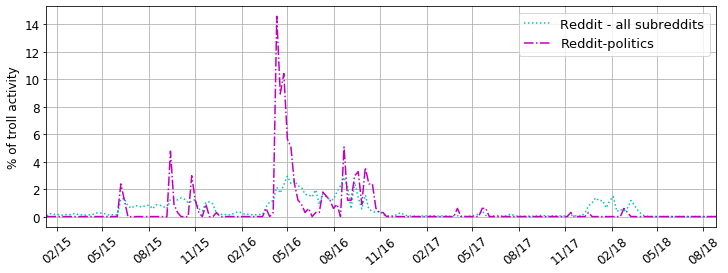

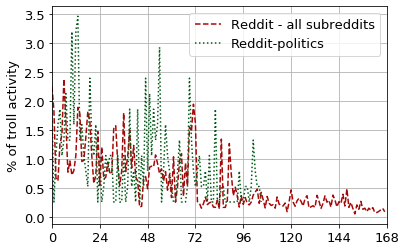

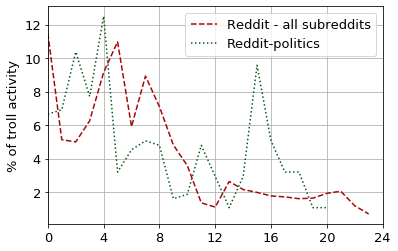

In [14]:
def get_counts_day2(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w')).count()
    #start_date = '2012-01-01'
    start_date = '2015-01-01'
    end_date = '2018-08-31'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    return counts_month

filter_days_all_general = []
dfs = [russians_reddit, russians_politics_subred]

keys = ['id', 'id']
for i in range(len(dfs)):
    df = dfs[i]
    k = keys[i]
    counts_day = get_counts_day2(df, k)
    counts_per_day = counts_day[k].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all_general.append(filter_days[1:])

    
def plot_days_counts(days_and_counts_list, colors, lines, path, leg=False, 
                     ylabel='% of troll activity'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = sum(counts)
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
            
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    
plot_days_counts(filter_days_all_general, colors[5:], line_styles[2:], path='C:/Users/Raju/Reddit-class/gov_trolls/figures/counts_per_day.jpg', 
                 leg=['Reddit - all subreddits', 'Reddit-politics'])

#datetimes_russian_full = russians_df_all['datetime'].tolist()
#datetimes_iranians = iranians_df_all['datetime'].tolist()
datetimes_russians_reddit = russians_reddit['datetime'].tolist()
datetimes_russians_politics_subred = russians_politics_subred['datetime'].tolist()
datetimes_all = [datetimes_russians_reddit, datetimes_russians_politics_subred]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%.1fK' % (x*1e-3)


def plot_hour_of_week(all_datetimes, colors, lines):
    percs_all = []
    for datetime_single in all_datetimes:
        counts = []
        for datetim in datetime_single:
            day = datetim.weekday()
            hour = datetim.hour
            hour_week = (day * 24) + hour
            counts.append(hour_week)
        data = Counter(counts).items()
        counts_only = [x[1] for x in data]
        percs = [(x/float(sum(counts_only)))*100 for x in counts_only ]
        percs_all.append(percs)
        
    xs = []
    for perc in percs_all:
        xs.append(np.arange(0, len(perc)))
    
    plt.figure(figsize=(6,4))
    for i in range(len(percs_all)):
        plt.plot(xs[i], percs_all[i], colors[i], linestyle=lines[i])
    plt.xlim(1, len(percs_all[0]))
    ax = plt.gca()
    plt.ylabel('% of troll activity')
    plt.grid()

    plt.xticks(np.arange(0, 169, 24))   

    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    plt.legend([ 'Reddit - all subreddits', 'Reddit-politics'], 
               loc='best', fontsize=13)

    plt.savefig('C:/Users/Raju/Reddit-class/gov_trolls/figures/counts_per_hour_week.jpg', bbox_inches='tight')
    plt.show()
                  
plot_hour_of_week(datetimes_all ,colors[1:], line_styles[1:])




def plot_hour_of_day(all_datetimes, colors, lines):

    percs_all = []
    for datetime_single in all_datetimes:
        counts = []
        for datetim in datetime_single:
            hour = datetim.hour
            counts.append(hour+1)
        data = Counter(counts).items()
        counts_only = [x[1] for x in data]
        percs = [(x/float(sum(counts_only)))*100 for x in counts_only ]
        percs_all.append(percs)
        
    xs = []
    for perc in percs_all:
        xs.append(np.arange(0, len(perc)))
    
    plt.figure(figsize=(6,4))
    for i in range(len(percs_all)):
        plt.plot(xs[i], percs_all[i], colors[i], linestyle=lines[i])
    plt.xlim(1, len(percs_all[0]))
    ax = plt.gca()
    plt.ylabel('% of troll activity')
    plt.grid()
    ax = plt.gca()
  
    plt.xticks(np.arange(0, 25, 4)) 

    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)
    
    plt.legend([ 'Reddit - all subreddits', 'Reddit-politics'], loc='best', fontsize=13)
    plt.savefig('C:/Users/Raju/Reddit-class/gov_trolls/figures/counts_per_hour_day.jpg', bbox_inches='tight')
    plt.show()
    

plot_hour_of_day(datetimes_all ,colors[1:], line_styles[1:])

## Figure 4 (Unique trolls that were active per week)¶

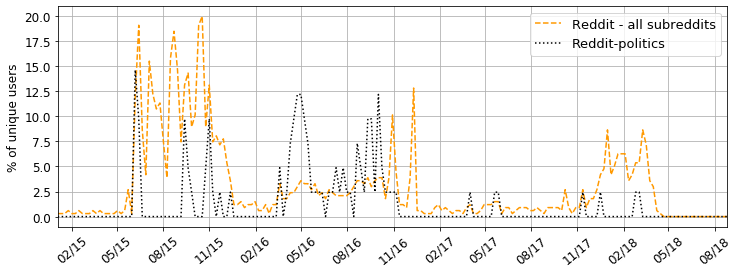

In [16]:
def get_unique_users_per_day(df, key):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq='w'))[key].nunique()    
    start_date = '2015-01-01'
    end_date = '2018-08-31'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq='w')
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)

    return counts_month

def plot_unique_users(days_and_counts_list, norm_counts, colors, lines, path, leg=False, ylabel='# of unique users'):
    percs_all = []
    fig, ax = plt.subplots(figsize=(12,4.5))
    k=0
    for days_and_counts in days_and_counts_list:
        counts = [x[0] for x in days_and_counts]
        d_s = norm_counts[k]
        days = [datetime.strptime(x[1], '%d-%m-%Y') for x in days_and_counts]
        days2 = mdates.date2num(days)
        percs = [x/float(d_s)*100 for x in counts]
        percs_all.append(percs)
        ax.plot_date(days2, percs, colors[k], linestyle=lines[k])
        k+=1
    
    months = mdates.MonthLocator(range(1,13), bymonthday=1, interval=3)
    monthsFmt = mdates.DateFormatter("%m/%y")
    
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()

    plt.ylabel(ylabel)
    plt.margins(x=0)
   
    plt.xticks(rotation=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
    for item in ([ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    plt.grid()
    plt.legend(leg, loc='best', fontsize=13)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    

dfs = [russians_reddit, russians_politics_subred]
keys = ['author','author']
filter_days_all = []
norms_all = []
for i in range(len(dfs)):
    df = dfs[i]
    counts_week = get_unique_users_per_day(dfs[i], keys[i])
    counts_per_week = counts_week.values
    weeks = counts_week.index
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_week, weeks) ]
    norm = len(set(df[keys[i]].tolist()))
    filter_days_all.append(filter_days)
    norms_all.append(norm)


plot_unique_users(filter_days_all, norms_all, colors[3:], line_styles[1:],
                  'C:/Users/Raju/Reddit-class/gov_trolls/figures/unique_users_per_week.jpg', ylabel='% of unique users',
                  leg=['Reddit - all subreddits', 'Reddit-politics'])